Epoch 0, Loss: 3.5044867992401123
Epoch 100, Loss: 1.5684007406234741
Epoch 200, Loss: 1.4564398527145386
Epoch 300, Loss: 1.4469763040542603
Epoch 400, Loss: 1.4440058469772339


C:\Users\14ken\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\14ken\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


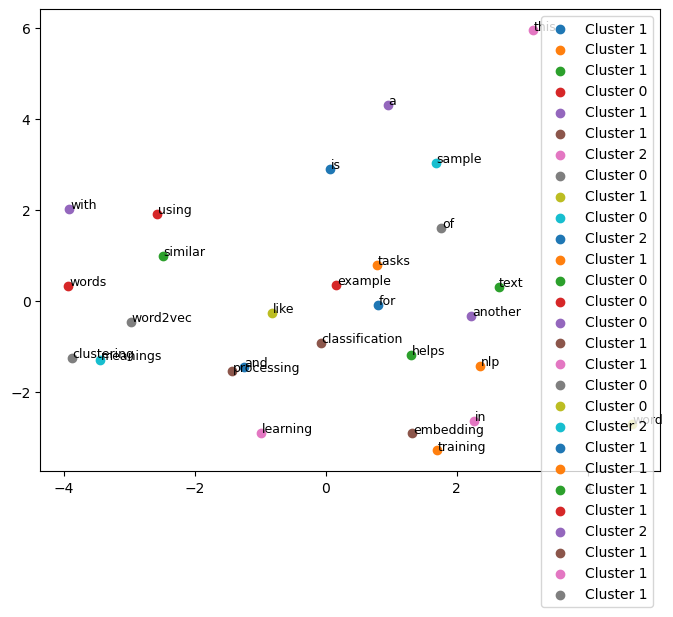

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import re
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Очистка текста
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.split()

# Пример текстов
corpus = [
    "This is a sample text for word embedding training.",
    "Another example of text processing and embedding learning.",
    "Clustering words with similar meanings using Word2Vec.",
    "Word embedding helps in NLP tasks like classification and clustering."
]

# Предобработка
tokenized_corpus = [preprocess_text(text) for text in corpus]
vocab = list(set([word for sentence in tokenized_corpus for word in sentence]))
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Создание обучающих данных (Skip-Gram)
def generate_training_data(tokenized_corpus, window_size=2):
    data = []
    for sentence in tokenized_corpus:
        for idx, word in enumerate(sentence):
            for neighbor in sentence[max(idx - window_size, 0): min(idx + window_size + 1, len(sentence))]:
                if neighbor != word:
                    data.append((word2idx[word], word2idx[neighbor]))
    return torch.tensor(data, dtype=torch.long)

training_data = generate_training_data(tokenized_corpus)

# Word2Vec модель (Skip-Gram)
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_size)
        self.output = nn.Linear(embed_size, vocab_size)
    
    def forward(self, input_word):
        embed = self.embeddings(input_word)
        out = self.output(embed)
        return out

# Параметры модели
embed_size = 10
model = Word2Vec(len(vocab), embed_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Обучение
num_epochs = 500
targets = training_data[:, 1]
inputs = training_data[:, 0]

for epoch in range(num_epochs):
    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Извлечение эмбеддингов
word_embeddings = model.embeddings.weight.detach().numpy()

# Кластеризация KMeans
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(word_embeddings)
labels = kmeans.labels_

# Визуализация
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(word_embeddings)
plt.figure(figsize=(8, 6))
for i, word in enumerate(vocab):
    plt.scatter(reduced_embeddings[i, 0], reduced_embeddings[i, 1], marker='o', label=f'Cluster {labels[i]}')
    plt.text(reduced_embeddings[i, 0] + 0.01, reduced_embeddings[i, 1] + 0.01, word, fontsize=9)
plt.legend()
plt.show()


In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "1"


Epoch 0, Loss: 81.6689
Epoch 100, Loss: 21.8379
Epoch 200, Loss: 21.7312
Epoch 300, Loss: 21.6991
Epoch 400, Loss: 21.6819


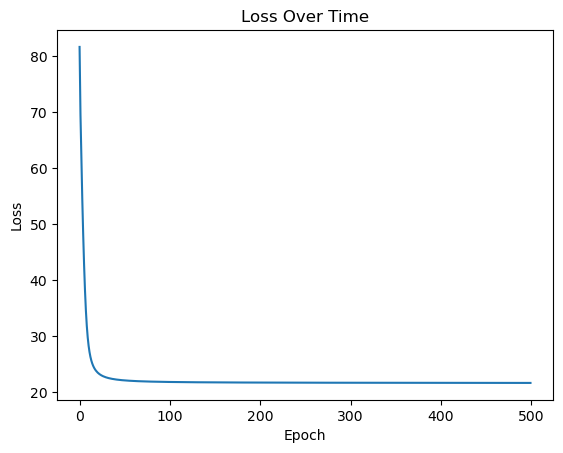

Кластер 1: король, мужчина, принц, двигатель, ученик, учитель
Кластер 2: женщина, королева, принцесса
Кластер 0: автомобиль, транспорт, капитан, корабль, море, школа


C:\Users\14ken\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import gensim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Устранение предупреждений sklearn
os.environ["OMP_NUM_THREADS"] = "1"

# Пример текстовых данных
data = [["король", "мужчина", "принц"],
        ["королева", "женщина", "принцесса"],
        ["автомобиль", "транспорт", "двигатель"],
        ["корабль", "море", "капитан"],
        ["учитель", "школа", "ученик"]]

# Подготовка данных
dictionary = gensim.corpora.Dictionary(data)
vocab_size = len(dictionary)
word2idx = dictionary.token2id
idx2word = {v: k for k, v in word2idx.items()}

# Создаем обучающие пары (входное слово -> целевое слово)
def generate_training_data(data):
    training_data = []
    window_size = 2  # Контекстное окно
    for sentence in data:
        indices = [word2idx[word] for word in sentence]
        for center_idx in range(len(indices)):
            for offset in range(-window_size, window_size + 1):
                context_idx = center_idx + offset
                if 0 <= context_idx < len(indices) and center_idx != context_idx:
                    training_data.append((indices[center_idx], indices[context_idx]))
    return training_data

training_data = generate_training_data(data)

# Гиперпараметры
embedding_dim = 10
learning_rate = 0.01
num_epochs = 500

# Определение модели Skip-gram
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
    
    def forward(self, center_word):
        embeds = self.embeddings(center_word)
        output = self.linear(embeds)
        return output

# Инициализация модели
model = Word2Vec(vocab_size, embedding_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
losses = []
for epoch in range(num_epochs):
    total_loss = 0
    for center, context in training_data:
        center_tensor = torch.tensor([center], dtype=torch.long)
        context_tensor = torch.tensor([context], dtype=torch.long)
        optimizer.zero_grad()
        output = model(center_tensor)
        loss = criterion(output, context_tensor)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

# Визуализация функции потерь
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.show()

# Получаем эмбеддинги слов
word_embeddings = model.embeddings.weight.detach().numpy()

# Кластеризация KMeans
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
kmeans.fit(word_embeddings)
labels = kmeans.labels_

# Вывод кластеров
clusters = {}
for word_id, cluster in enumerate(labels):
    word = idx2word[word_id]
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(word)

for cluster, words in clusters.items():
    print(f"Кластер {cluster}: {', '.join(words)}")
